In [2]:
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re
import string
import sys
from autocorrect import Speller
from nltk.tokenize import word_tokenize
from pyspark.sql import Row, functions, types
from sklearn.manifold import TSNE
from typing import Dict, List, Iterable, Tuple


In [3]:
sys.path.append("../../")

from src.ingestion.database.reader import *

reader = IngestionReader(
    db_host="127.0.0.1", db_user="postgres",
    db_password="0f21e4cd-44f8-48ab-b112-62030d7f7df1",
    jdbc_driver_path="../../third_party/postgresql-42.5.0.jar")


22/11/13 22:49:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
contents = ReadContents(reader)

credits = contents.\
    filter(contents["tmdb_id"].isNotNull()).\
    filter(contents["tmdb_credits"] != "null").\
    select(["tmdb_id", "tmdb_credits"])

credits.show()


+-------+--------------------+
|tmdb_id|        tmdb_credits|
+-------+--------------------+
|  91261|{"id": 91261, "ca...|
| 246743|{"id": 246743, "c...|
|  27563|{"id": 27563, "ca...|
|  87992|{"id": 87992, "ca...|
|   3764|{"id": 3764, "cas...|
|  11190|{"id": 11190, "ca...|
| 250622|{"id": 250622, "c...|
| 505481|{"id": 505481, "c...|
|  13723|{"id": 13723, "ca...|
| 110729|{"id": 110729, "c...|
|  28762|{"id": 28762, "ca...|
| 367056|{"id": 367056, "c...|
|  15173|{"id": 15173, "ca...|
|  16530|{"id": 16530, "ca...|
|  73273|{"id": 73273, "ca...|
| 531208|{"id": 531208, "c...|
|  23506|{"id": 23506, "ca...|
|  12568|{"id": 12568, "ca...|
| 163997|{"id": 163997, "c...|
|  11625|{"id": 11625, "ca...|
+-------+--------------------+
only showing top 20 rows



Actor and crew composition

In [5]:
def ExtractDepartment(row: Row) -> Row:
    c = json.loads(row["tmdb_credits"])
    casts = c["cast"]
    crews = c["crew"]

    for cast in casts:
        if "known_for_department" not in cast:
            continue

        yield Row(tmdb_id=row["tmdb_id"],
                  cast_department=cast["known_for_department"],
                  crew_department=None)
    
    for crew in crews:
        if "known_for_department" not in crew:
            continue

        yield Row(tmdb_id=row["tmdb_id"],
                  cast_department=None,
                  crew_department=crew["known_for_department"])

content_departments = credits.\
    rdd.\
    flatMap(ExtractDepartment).\
    toDF()

content_departments.show()


+-------+---------------+---------------+
|tmdb_id|cast_department|crew_department|
+-------+---------------+---------------+
|  91261|         Acting|           null|
|  91261|         Acting|           null|
|  91261|      Directing|           null|
|  91261|         Acting|           null|
|  91261|         Acting|           null|
|  91261|         Acting|           null|
|  91261|         Acting|           null|
|  91261|         Acting|           null|
|  91261|         Acting|           null|
|  91261|           null|            Art|
|  91261|           null|         Camera|
|  91261|           null|      Directing|
|  91261|           null|        Writing|
|  91261|           null|          Sound|
|  91261|           null|     Production|
|  91261|           null|        Editing|
| 246743|         Acting|           null|
| 246743|         Acting|           null|
| 246743|         Acting|           null|
| 246743|         Acting|           null|
+-------+---------------+---------

In [6]:
all_departments = content_departments.\
    select("cast_department").withColumnRenamed("cast_department", "department").\
    union(other=content_departments.select("crew_department")).withColumnRenamed("crew_department", "department").\
    distinct().\
    where(functions.col("department").isNotNull()).\
    sort("department")

all_departments.collect()


[Row(department='Acting'),
 Row(department='Actors'),
 Row(department='Art'),
 Row(department='Camera'),
 Row(department='Costume & Make-Up'),
 Row(department='Creator'),
 Row(department='Crew'),
 Row(department='Directing'),
 Row(department='Editing'),
 Row(department='Lighting'),
 Row(department='Production'),
 Row(department='Sound'),
 Row(department='Visual Effects'),
 Row(department='Writing')]

In [7]:
content_departments.\
    groupBy(["tmdb_id", "crew_department"]).\
    agg(functions.count("crew_department")).\
    sort(["tmdb_id", "crew_department"]).\
    show()


+-------+-----------------+----------------------+
|tmdb_id|  crew_department|count(crew_department)|
+-------+-----------------+----------------------+
|      2|             null|                     0|
|      2|           Acting|                     4|
|      2|              Art|                     2|
|      2|           Camera|                     5|
|      2|Costume & Make-Up|                     1|
|      2|             Crew|                     2|
|      2|        Directing|                     5|
|      2|          Editing|                     5|
|      2|         Lighting|                     2|
|      2|       Production|                     5|
|      2|            Sound|                     4|
|      3|             null|                     0|
|      3|           Acting|                     2|
|      3|              Art|                     1|
|      3|           Camera|                     5|
|      3|Costume & Make-Up|                     2|
|      3|        Directing|    

In [8]:
content_actor_counts = content_departments.\
    groupBy("tmdb_id").\
    agg(functions.count("cast_department")).\
    sort("tmdb_id").\
    collect()

In [9]:
actor_counts = list()
for row in content_actor_counts:
    actor_counts.append(row["count(cast_department)"])

actor_counts = np.array(actor_counts)
actor_counts


array([38, 33, 25, ..., 16, 10,  1])

average #actors= 18.331906082195626
median #actors= 14.0
std #actors= 16.48086449832149


(array([1.0072e+04, 1.6627e+04, 1.1841e+04, 7.3010e+03, 3.5760e+03,
        2.5630e+03, 1.6220e+03, 9.6200e+02, 8.0000e+02, 4.6600e+02,
        3.4300e+02, 2.2300e+02, 1.4700e+02, 1.1500e+02, 6.8000e+01,
        6.3000e+01, 4.3000e+01, 3.5000e+01, 3.0000e+01, 1.6000e+01,
        1.9000e+01, 1.1000e+01, 6.0000e+00, 8.0000e+00, 4.0000e+00,
        4.0000e+00, 2.0000e+00, 5.0000e+00, 3.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0. ,   6.6,  13.2,  19.8,  26.4,  33. ,  39.6,  46.2,  52.8,
         59.4,  66. ,  72.6,  79.2,  85.8,  92.4,  99. , 105.6, 112.2,
        118.8, 125.4, 132. , 138.6, 145.2, 151.8, 158.4, 165. , 171.6,
        178.2, 184.8, 191.4, 198. , 204.6, 211.2, 217.8, 224.4, 231. ,
        237.6, 244.2, 250.8, 257.4

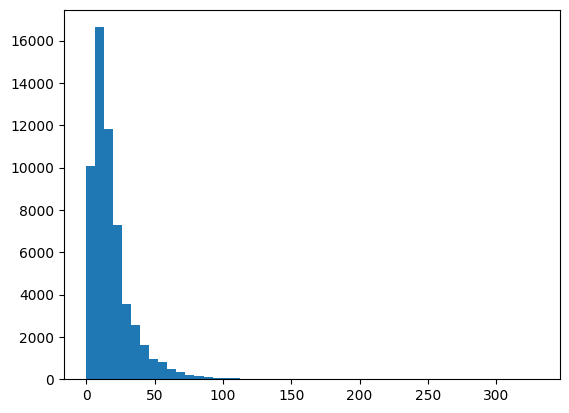

In [10]:
print("average #actors=", np.mean(actor_counts))
print("median #actors=", np.median(actor_counts))
print("std #actors=", np.std(actor_counts))

plt.hist(x=actor_counts, bins=50)

In [11]:
transformed_actor_counts = (actor_counts - np.mean(actor_counts))/np.std(actor_counts)

(array([1.0072e+04, 1.6627e+04, 1.1841e+04, 7.3010e+03, 4.0260e+03,
        2.1130e+03, 1.6220e+03, 9.6200e+02, 8.0000e+02, 5.3800e+02,
        2.7100e+02, 2.2300e+02, 1.4700e+02, 1.1500e+02, 6.8000e+01,
        6.3000e+01, 4.3000e+01, 3.5000e+01, 3.0000e+01, 2.2000e+01,
        1.3000e+01, 1.1000e+01, 6.0000e+00, 8.0000e+00, 4.0000e+00,
        4.0000e+00, 2.0000e+00, 5.0000e+00, 3.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-1.11231459, -0.71185016, -0.31138573,  0.0890787 ,  0.48954313,
         0.89000756,  1.29047198,  1.69093641,  2.09140084,  2.49186527,
         2.8923297 ,  3.29279413,  3.69325856,  4.09372299,  4.49418742,
         4.89465185,  5.29511628,  5.69558071,  6.09604514,  6.49650957,
         6.896974  ,  7.29

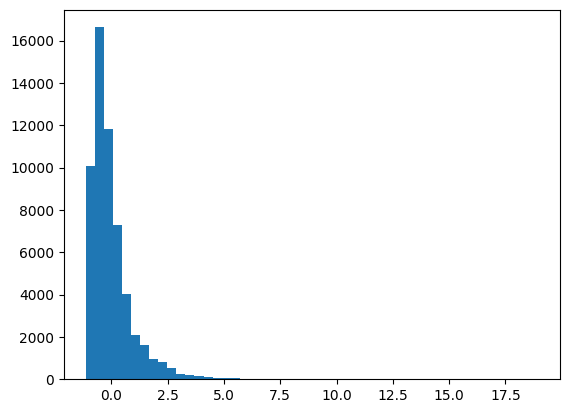

In [12]:
plt.hist(x=transformed_actor_counts, bins=50)
